In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [5]:
from torchvision import datasets, transforms

train_data = datasets.MNIST(root='data', 
    train=True, download=True, 
    transform=transforms.Compose([
            transforms.ToTensor()
    ]))

train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=64, num_workers=0)

In [6]:
image, label = next(iter(train_loader))

In [12]:
img = image[0]
img.shape

torch.Size([1, 28, 28])

In [24]:
img


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

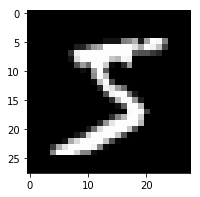

In [15]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(img.numpy().squeeze(), cmap='gray')

In [28]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle as pkl


class Discriminator(nn.Module):
    def __init__(self, input_size=784, hidden_dim=32, output_size=1):
        super().__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):  
        # flatten
        x = x.view(-1, 28 * 28)        
        
        # hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)   
        
        # final layer
        x = self.fc4(x)
        
        return x
        
class Generator(nn.Module):
    
    def __init__(self, input_size=100, hidden_dim=32, output_size=784):
        super().__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # output
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        # output
        x = F.tanh(self.fc4(x))
        
        return x        


D = Discriminator()
G = Generator()

def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:    
        labels = torch.ones(batch_size)
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


lr = 0.002
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)


test_z = np.random.uniform(-1, 1, size=(16, 100))
test_z = torch.from_numpy(test_z).float()

D.train()
G.train()

losses = []
samples = []
for epoch in range(100):
    for batch_i, (real_images, _) in enumerate(train_loader):
        # training Discriminator
        real_images = real_images*2 - 1
        
        d_optimizer.zero_grad()
        d_real_out = D(real_images)
        d_real_loss = real_loss(d_real_out, smooth=True)
        
        
        # generate fake iamges
        batch_size = real_images.size(0)
        z = np.random.uniform(-1, 1, size=(batch_size, 100))
        z = torch.from_numpy(z).float()        
        fake_image = G(z)
        
        
        d_fake_out = D(fake_image)
        d_fake_loss = fake_loss(d_fake_out)
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # training Generator
        g_optimizer.zero_grad()
        
        z = np.random.uniform(-1, 1, size=(batch_size, 100))
        z = torch.from_numpy(z).float()            
        fake_images = G(z)
        
        D_fake = D(fake_images)        
        g_loss = real_loss(D_fake)
                
        g_loss.backward()
        g_optimizer.step()
        
        if batch_i % 400 == 0:
            print('Epoch {} | d_loss: {:.3f} | g_loss: {:.3f}'.format(
                epoch+1,
                d_loss.item(),
                g_loss.item()
            ))
        
        
    losses.append((d_loss.item(), g_loss.item()))
        
        
    # evaluate Generator    
    G.eval()
    sample_z = G(test_z)
    samples.append(sample_z)
    G.train()
    
    
        
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)        
        
        
        
        


/Users/mondormo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 1 | d_loss: 1.424 | g_loss: 0.615
Epoch 1 | d_loss: 0.853 | g_loss: 2.257
Epoch 1 | d_loss: 1.276 | g_loss: 0.931
Epoch 2 | d_loss: 1.437 | g_loss: 2.096
Epoch 2 | d_loss: 1.197 | g_loss: 1.108
Epoch 2 | d_loss: 1.368 | g_loss: 0.761
Epoch 3 | d_loss: 1.207 | g_loss: 1.101
Epoch 3 | d_loss: 1.065 | g_loss: 1.243
Epoch 3 | d_loss: 1.244 | g_loss: 1.246
Epoch 4 | d_loss: 1.081 | g_loss: 0.988
Epoch 4 | d_loss: 1.233 | g_loss: 1.120
Epoch 4 | d_loss: 1.329 | g_loss: 0.966
Epoch 5 | d_loss: 1.237 | g_loss: 0.904
Epoch 5 | d_loss: 1.209 | g_loss: 0.866
Epoch 5 | d_loss: 1.254 | g_loss: 0.988
Epoch 6 | d_loss: 1.292 | g_loss: 2.245
Epoch 6 | d_loss: 1.217 | g_loss: 0.960
Epoch 6 | d_loss: 1.216 | g_loss: 0.972
Epoch 7 | d_loss: 1.406 | g_loss: 1.599
Epoch 7 | d_loss: 1.213 | g_loss: 1.684
Epoch 7 | d_loss: 1.330 | g_loss: 1.311
Epoch 8 | d_loss: 1.197 | g_loss: 1.401
Epoch 8 | d_loss: 1.049 | g_loss: 2.532
Epoch 8 | d_loss: 1.366 | g_loss: 2.021
Epoch 9 | d_loss: 1.229 | g_loss: 1.094


Epoch 68 | d_loss: 1.306 | g_loss: 1.231
Epoch 68 | d_loss: 1.246 | g_loss: 1.028
Epoch 68 | d_loss: 1.264 | g_loss: 1.075
Epoch 69 | d_loss: 1.200 | g_loss: 1.333
Epoch 69 | d_loss: 1.256 | g_loss: 0.933
Epoch 69 | d_loss: 1.314 | g_loss: 1.217
Epoch 70 | d_loss: 1.287 | g_loss: 1.009
Epoch 70 | d_loss: 1.304 | g_loss: 1.104
Epoch 70 | d_loss: 1.351 | g_loss: 0.969
Epoch 71 | d_loss: 1.247 | g_loss: 0.809
Epoch 71 | d_loss: 1.296 | g_loss: 0.923
Epoch 71 | d_loss: 1.415 | g_loss: 0.878
Epoch 72 | d_loss: 1.298 | g_loss: 0.878
Epoch 72 | d_loss: 1.266 | g_loss: 1.041
Epoch 72 | d_loss: 1.412 | g_loss: 0.971
Epoch 73 | d_loss: 1.317 | g_loss: 0.942
Epoch 73 | d_loss: 1.250 | g_loss: 0.894
Epoch 73 | d_loss: 1.299 | g_loss: 1.055
Epoch 74 | d_loss: 1.216 | g_loss: 0.994
Epoch 74 | d_loss: 1.292 | g_loss: 0.966
Epoch 74 | d_loss: 1.365 | g_loss: 0.912
Epoch 75 | d_loss: 1.287 | g_loss: 1.130
Epoch 75 | d_loss: 1.158 | g_loss: 1.379
Epoch 75 | d_loss: 1.392 | g_loss: 1.099
Epoch 76 | d_los

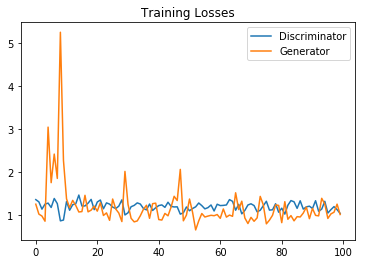

In [29]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [30]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [31]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

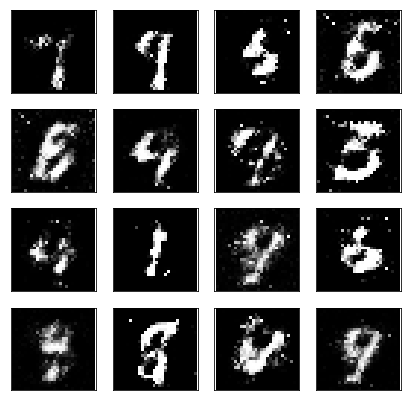

In [38]:
view_samples(20, samples)